<center><h1>What's my job?!</h1>
    <h2>Predicting your job using Tensorflow</h2></center>

In [3]:
import requests
from bs4 import BeautifulSoup

import re
import os
import time

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.1.0


[nltk_data] Downloading package stopwords to /home/robin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<img src="https://miro.medium.com/max/600/0*a6XSwHsfvz_oWSSJ.jpg">

## Get the data

Below is a function that scrapes text from Indeed.

In [48]:
def scraper(job_titles):

    job_openings = [] # list with job opening text
    labels = [] # list with job opening labels
    urls = [] # list with all the job urls

    main = "https://www.indeed.com" # main indeed url

    for item in job_titles:

        job = '"' + item.replace(" ", "+") + '"' # replace space in job title with dash

        print(job)

        for number in range(0, 15000, 10): # will scrape 15.000 job openings per job, in increments of 10

            print(f"starting first {number} of {item}")

            url = f"{main}/jobs?q={job}&start={number}" # compile job specific url

            print(url)
            
            try: # in case we get an error when requesting te page.
                page = requests.get(url) # request url
            except:
                break
                print("An error occured")
            
            time.sleep(2)

            soup = BeautifulSoup(page.content, "html.parser") # parse the page with beautifulsoup

            links = [a['href'] for a in soup.find_all('a', href=True)] # find all the urls on the page

            match_links = [main+s for s in links if "rc/clk?jk=" in s] # find all the urls that link to job page
            
            print(len(match_links))

            for link in match_links: # loop through the 10 job ad urls on the page
                
                print(link)
                
                try: # in case we get an error requesting the page
                    job_page = requests.get(link) # request the job ad url
                except:
                    break
                    print("An error occured")
                    
                time.sleep(3) # wait a few seconds to not overlad server
                job_soup = BeautifulSoup(job_page.content, "html.parser") # parse the page

                for element in job_soup.find_all('div', attrs={"class":"jobsearch-jobDescriptionText"}): # loop through the job text
                    text = element.get_text(separator = " ").replace("\n","") # remove all tags from job text
                    
                    job_openings.append(text) # append job text tot job_openings
                    labels.append(item) # append job title
                    urls.append(link) # append link
            
            

            if len(match_links) < 2: # breaks the loop if we are at the end of the # of jobs
                break                    
    
    return job_openings, labels, urls

The scraper can take a list with any number of job titles and will take the first 2.000 job openings.

In [ ]:
job_openings = ["data analyst",
                "sales manager",
                "marketing manager",
                "event manager"] # list of jobs I want to scrape

jobs, labels, links = scraper(job_openings)

Save the 3 lists as 1 Pandas dataframe, and save a copy of the dataframe as csv.

In [ ]:
jobs_df = pd.DataFrame(
                        {'job_text': jobs,
                         'labels': labels,
                         'url': links
                        }) # create new dataframe with 3 columns

jobs_df.to_csv('data/jobs-data2.csv', index=False) # save dataframe to csv

## Preparing the data

First, load the csv and randomize the data. I randomize because at a later stage we will need a mixed train/test split. I will also look for duplicate job texts. For example, a job might be in the search results for business analyst and data analyst.

In [165]:
df = pd.read_csv("data/jobs-data2.csv") # load the csv from file
df = df.sample(frac=1).reset_index(drop=True) # randomize the data

df_clean = df.drop_duplicates(subset="url", keep="first") # drop duplicate job_text, but keep the first

In [191]:
df_clean.head()

,job_text,labels,url
0,A completed Bachelor's Degree from an accredit...,event manager,https://www.indeed.com/rc/clk?jk=81c7b3348cae5...
1,Live! at the Battery Atlanta opened along with...,sales manager,https://www.indeed.com/rc/clk?jk=c595a86304cd4...
2,"At Great Wolf, the Manager of Kids Experience...",event manager,https://www.indeed.com/rc/clk?jk=5f1b812c1bcca...
3,EBSCO Information Services (EIS) provides a co...,event manager,https://www.indeed.com/rc/clk?jk=f22dcdd8be509...
4,Senior Marketing Manager - Ventilated Consumab...,marketing manager,https://www.indeed.com/rc/clk?jk=5185b28591b22...


In [166]:
print(df.shape) # shape with duplicates
print(df_clean.shape) # shape without duplicates

(19057, 3)
(3002, 3)


I'm seeing that a massive amount of data has been lost due to duplicates. After closer examination I've found that I scraped the same job text from the same url multiple times (sometimes even more than 20 times). It looks like many pages have the exact same set of jobs. I could improve the scraper by only adding jobs that are not already scraped.

In [167]:
df_clean.groupby('labels').count() # count per category

,job_text,url
labels,,
data analyst,185,185
event manager,1004,1004
marketing manager,872,872
sales manager,941,941


I'll upsample all the classes to match the event manager class.

In [168]:
from sklearn.utils import resample

samples = len(df_clean.loc[df_clean['labels'] == 'event manager']) - len(df_clean.loc[df_clean['labels'] == 'data_analyst'])
print(samples)

upsample_data_analyst = resample(df_clean.loc[df_clean['labels'] == 'data analyst'],
                          replace=True,
                          n_samples=len(df_clean.loc[df_clean['labels'] == 'event manager']),
                          random_state=42)

df_upsample = pd.concat([df_clean, upsample_data_analyst], ignore_index=True)

1004


Someone pointed out to me that, next time, I should only upsample the training set. Anyway, below are the new counts.

In [169]:
df_upsample.groupby('labels').count() # count per category

,job_text,url
labels,,
data analyst,1189,1189
event manager,1004,1004
marketing manager,872,872
sales manager,941,941


Let's see what happens if we continue with this dataset.

My next step will be to make the label column numeric.

In [170]:
conditions = [(df_upsample['labels'] == 'data analyst'),
    (df_upsample['labels'] == 'event manager'),
    (df_upsample['labels'] == 'marketing manager'),
    (df_upsample['labels'] == 'sales manager')] # make a list with all the conditions

choices = [0, 1, 2, 3] # make a list with all the numeric values

df_upsample['labels_num'] = np.select(conditions, choices) # make label column numeric

df_upsample = df_upsample.sample(frac=1).reset_index(drop=True) # randomize the data

I don't want the cv classifier to base it's prediction one someone having a certain job title in their cv. I want to train the model based on other skills necessary. Therefore, I'm stripping the job titles from the job text.

In [172]:
job_openings = ["data analyst",
                "event manager",
                "marketing manager",
                "sales manager"] # list of jobs I want to scrape

for item in job_openings: # for every job, replace the substring with nothing.
    df_upsample['job_text'] = df_upsample['job_text'].str.replace(item, '', case=False)
    
jobs = df_upsample['job_text'].to_numpy() # convert to numpy array
labels = df_upsample['labels_num'].to_numpy() # convert to numpy array

Then, remove the stopwords

In [173]:
jobs_clean = []

for i in jobs:
    job = i
    for word in STOPWORDS: # STOPWORDS is set in the beginning
        token = ' ' + word + ' '
        job = job.replace(token, ' ')
        job = job.replace(' ', ' ')
    jobs_clean.append(job)

Then, set our paramaters

In [174]:
vocab_size = 1000 # the vocabulary will include de 1000 most common words
embedding_dim = 128 # vector dimension of embedding layer
max_length = 600 # the max length of each job text
trunc_type = 'post' # truncate the end of text
padding_type = 'post' # pad the end of text
oov_tok = '<OOV>' # not in word index
training_portion = .8 # portion of training set

One-hot-encode label column

In [175]:
labels = tf.keras.utils.to_categorical(labels, num_classes=4)

Convert them to a train and test set

In [176]:
train_size = int(len(jobs_clean) * training_portion)

train_jobs = jobs_clean[0: train_size]
train_labels = labels[0: train_size]

validation_jobs = jobs_clean[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_jobs))
print(len(train_labels))
print(len(validation_jobs))
print(len(validation_labels))

3204
3204
3204
802
802


Tokenizer

OOV is the most common, followed by experience, etc.

In [177]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_jobs)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'experience': 2,
 'data': 3,
 'work': 4,
 'sales': 5,
 'business': 6,
 'marketing': 7,
 'team': 8,
 'skills': 9,
 'ability': 10}

Turn into list of sequence

In [178]:
train_sequences = tokenizer.texts_to_sequences(train_jobs)
print(train_sequences[10]) # 11th job opening

[13, 184, 293, 793, 276, 321, 23, 567, 349, 675, 352, 26, 1, 1, 80, 10, 95, 5, 80, 556, 126, 1, 22, 429, 1, 352, 26, 624, 1, 1, 1, 285, 1, 204, 352, 26, 1, 1, 1, 1, 5, 1, 879, 31, 204, 1, 1, 590, 780, 1, 5, 879, 31, 793, 276, 321, 8, 1, 1, 1, 25, 234, 19, 445, 648, 299, 364, 71, 1, 1, 1, 149, 625, 670, 1, 1, 1, 1, 1, 117, 219, 538, 229, 335, 283, 920, 1, 149, 214, 1, 1, 1, 1, 1, 286, 1, 1, 310]


Pad sequences so they are all the same size. train_padded is length 600

In [179]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0])) # old
print(len(train_padded[0])) # new

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

441
600
363
600
98
600


Do the same for validation sequences

In [180]:
validation_sequences = tokenizer.texts_to_sequences(validation_jobs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

802
(802, 600)


Compare original job text and job text after padding and tokenization

In [181]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_job(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_job(train_padded[12]))
print('---')
print(train_jobs[12])

job description you we looking high energy software sales director help team identify bring <OOV> <OOV> <OOV> product service opportunities your team expected generate <OOV> new business well maintaining growing relationships existing accounts you team responsible overall health sales performance territory <OOV> accounts us <OOV> build <OOV> we come join <OOV> new <OOV> <OOV> applications platform business unit <OOV> made products services <OOV> portfolio help customers build <OOV> manage important applications we build applications <OOV> <OOV> cloud <OOV> environment <OOV> open <OOV> <OOV> <OOV> manage <OOV> <OOV> <OOV> <OOV> help achieve business outcomes your day <OOV> c level clients leading <OOV> coaching high performance sales team <OOV> <OOV> <OOV> sales leadership driving digital <OOV> strategy market leading enterprise customers required skills experiences ability influence others achieve results ability lead <OOV> direct group diverse <OOV> individuals ability prioritize proj

## Building the model

<img src="https://tweakers.net/i/1UCdBTvgCLy3op9dVLMxsboAckU=/656x/filters:fill(white)/i/2001747173.png?f=imagenormal">

I will use a LSTM neural net to train my classifier. Because I have a very small dataset, I have added a dropout layer.

In [182]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 424,580
Trainable params: 424,580
Non-trainable params: 0
_________________________________________________________________


Below, I'be brought down the learning rate to improve the classifier.

In [187]:
train_padded_array = np.asarray(train_padded)

opt = tf.keras.optimizers.Adam(learning_rate=0.00075)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
num_epochs = 20
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Train on 3204 samples, validate on 802 samples
Epoch 1/20
3204/3204 - 409s - loss: 0.1901 - accuracy: 0.9373 - val_loss: 0.7979 - val_accuracy: 0.7905
Epoch 2/20
3204/3204 - 406s - loss: 0.1729 - accuracy: 0.9429 - val_loss: 0.9211 - val_accuracy: 0.7681
Epoch 3/20
3204/3204 - 402s - loss: 0.1490 - accuracy: 0.9498 - val_loss: 0.8861 - val_accuracy: 0.7968
Epoch 4/20
3204/3204 - 401s - loss: 0.1472 - accuracy: 0.9498 - val_loss: 0.8396 - val_accuracy: 0.7943
Epoch 5/20
3204/3204 - 409s - loss: 0.1465 - accuracy: 0.9466 - val_loss: 0.8729 - val_accuracy: 0.8005
Epoch 6/20
3204/3204 - 405s - loss: 0.1514 - accuracy: 0.9473 - val_loss: 0.8445 - val_accuracy: 0.8005
Epoch 7/20
3204/3204 - 404s - loss: 0.1400 - accuracy: 0.9516 - val_loss: 0.8801 - val_accuracy: 0.7830
Epoch 8/20
3204/3204 - 405s - loss: 0.1282 - accuracy: 0.9535 - val_loss: 0.9217 - val_accuracy: 0.8005
Epoch 9/20
3204/3204 - 402s - loss: 0.1190 - accuracy: 0.9594 - val_loss: 0.9582 - val_accuracy: 0.7968
Epoch 10/20
3204/

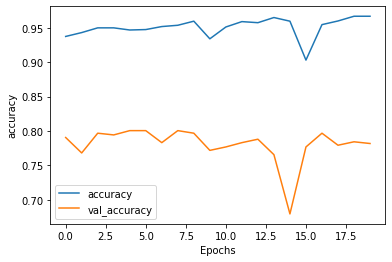

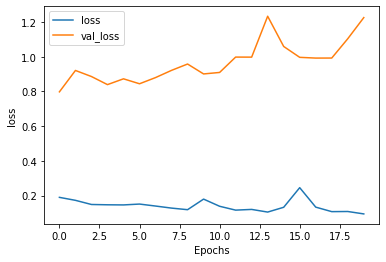

In [188]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Model is cleary overfitting. However, I've managed to reduce overfitting drastically compared to earlier versions of my neural net by experimenting with different parameters.

Some of the steps I can take to improve:

<ul>
    <li>Get more data</li>
    <li>Keep experiment with different parameters</li>
    <li>Experiment with a simpler neural net</li>
    <li>Upsample after train/test split</li>
</ul>

## Save model

I will save the model and the tokenizer for use in my app.

In [189]:
model.save('cv-classifier/app/assets/model1.h5')

In [190]:
import pickle

# saving
with open('cv-classifier/app/assets/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('cv-classifier/app/assets/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)